# Step-Index Fibre

The fibre is subject to the refractive index profile
$$
n(r\leq a) = n_\mathrm{core}\\
n(r > a) = n_\mathrm{clad}\\
$$

and field subject to the boundary conditions
$$
E(r^{(-)}=a) = E(r^{(+)}=a)\\
E^\prime(r^{(-)}=a) = E^\prime(r^{(+)}=a)
$$
where $r^{(-)}$ and $r^{(+)}$ refer to the radial co-ordinate when approacing from $-\infty$ and $+\infty$ respectively.

The solution is
$$
E(r,\phi,z,t) = \sum_{lm} \psi_{lm}(r) e^{il\phi} e^{i\beta_{lm} z} e^{-i\omega t} \left|a_{lm}\right|e^{i\theta_{lm}}
$$

with
$$
\psi_{lm}(r) = \begin{cases}
A_{lm} J_l\left(u_{lm}\frac{r}{a}\right) & r\leq a\\
A_{lm} \frac{J_l\left(u_{lm}\right)}{K_l\left(w_{lm}\right)} K_l\left(w_{lm}\frac{r}{a}\right) & r\geq a
\end{cases}
$$

where 
$$
u_{lm} = a\sqrt{n_\mathrm{core}^2k_0^2 - \beta_{lm}^2}\\
w_{lm} = a\sqrt{\beta_{lm}^2 - n_\mathrm{clad}^2k_0^2}
$$ 
where $J_l$ is the Bessel function of the _1<sup>st</sup>_ kind, and $K_l$ is the modified Bessel function of the _2<sup>nd</sup>_ kind.

For the mode to be propagating, $u_{lm}$ and $w_{lm}$ must be real, thus
$$
n_\mathrm{clad} \leq \beta_{lm}/k_0 \leq n_\mathrm{core}
$$ 

The above expressions ensure continuity across the boundary, but it is also necessary to enforce a continuous gradient, yielding the following expression.

$$
u_{lm} \frac{
    J_{l\pm 1}\left(u_{lm}\right)
}{
    J_{l}\left(u_{lm}\right)
} = \pm w_{lm} \frac{
    K_{l\pm 1}\left(w_{lm}\right)
}{
    K_{l}\left(w_{lm}\right)
}
$$
Note that $u_{lm}$ does not correspond to the zeros of the Bessel function.

From this, taking the negative signs, one can conclude
$$
j_{l-1,m} < V < j_{l,m}
$$
where the roots of the Bessel function are labelled $j_{lm}$, i.e.$J_l(j_{lm}) = 0$.

**Note that for $l=0$, there is also an additional solution for the fundamental mode**

This transcendental equation is easier to solve with the following expressions for the normalized frequency, $V$, and normalized propagation constants, $b_{lm}$ respectively:
$$
V = \sqrt{u_{lm}^2 + w_{lm}^2}
= a k_0 \sqrt{n_\mathrm{core}^2 - n_\mathrm{clad}^2}
= a k_0 \mathrm{NA}
= a k_0 n_\mathrm{core} \sqrt{2\Delta}\\

b_{lm} = 1 - \left(\frac{u_{lm}}{w_{lm}}\right)^2
= \left(\frac{w_{lm}}{V}\right)^2
= \frac{\left(\frac{\beta_{lm}}{k_0}\right)^2 - n_\mathrm{clad}^2}{(n_\mathrm{core}^2 - n_\mathrm{clad}^2)}
= \frac{\bar{n}^2 - n_\mathrm{clad}^2}{\mathrm{NA}^2}
$$

leading to the substitutions 
$$
w_{lm} = V \sqrt{b_{lm}},\quad
u_{lm} = V \sqrt{1 - b_{lm}}.
$$ 
Note the subscripts $lm$ are often dropped from the expressions for $u$, $w$, $b$ and $\beta$, although they are mode dependent; $V$, the normalized frequency, however is mode independent and is a parameter of the fibre itself.

The solutions to the eigenvalue equation can be solved using standard root-finding methods, bracketed by the roots of the Bessel function. Once the value of b is found, the propagation constant can then easily be calculated.

In [99]:
import numpy as np
from numpy.typing import NDArray
from scipy import special, optimize, linalg
import json
from matplotlib import pyplot as plt

import AppendPath
from software.hankel_transform import HankelTransform as HT
from software.utils import col, row

# # Smallest difference from 1
eps = np.spacing(1)

PI = np.pi
TAU = 2*PI

## Functions

In [86]:
# Refractive index of bulk fused silica (SiO2) - Malitson (1965)
def ref_index_fused_silica(l_um: NDArray) -> NDArray:
    return np.sqrt(
        1
        + 0.6961663 / (1 - (0.0684043 / l_um) ** 2)
        + 0.4079426 / (1 - (0.1162414 / l_um) ** 2)
        + 0.8974794 / (1 - (9.896161 / l_um) ** 2)
    )

# Calculate the maximum number of modes (propagation constant must be real)
#  u_max = V
def num_modes(V: float, l: int = 0, Nm: int = 10):
    j_lm = lambda Nm: special.jn_zeros(l-1, Nm)
    Nm = max(Nm, 1)
    roots_lm1 = j_lm(Nm)
    while roots_lm1[-1] < V:
        Nm *= 2
        roots_lm1 = j_lm(Nm)
    # For l=0, include the first root larger than V
    return sum(roots_lm1 < V).item() + (l==0)

## Define Fibre Parameters

In [87]:
l0 = 633e-3 # Wavelength [um]
k0 = TAU/l0
d = 10 # Core diameter [um]
a = d/2 # Fibre radius [um]
NA = 0.1 # Numerical aperture

n_clad = ref_index_fused_silica(l0) # Ref. index of cladding
# n_clad = 1.457
n_core = np.sqrt(NA**2 + n_clad**2) # Ref. index of core

# Normalized frequency
V = a * k0 * NA

## Find number of modes

For a given $l$, find number of roots, $J_l(\rho_{lm})=0$ such that $\rho_{lm} \leq V$.

For $l=0$, there are 2 modes per root ()
For $l\geq1$, there are 4 modes per root ($\pm l$ and two polarizations).

In [88]:
N_lm = []
l = 0
while True:
    if (Nm := num_modes(V, l))==0:
        break
    N_lm.append(Nm)
    l += 1

# Display results
print("Number of solutions N_lm:", N_lm)
print("Valid LP modes:")
_ = [print(f"LP_{l}{m}") for l, N_l in enumerate(N_lm) for m in range(N_l)]
print(f"V = {V:.3f}")
print(f"Approximate number of modes (V^2/2): {V**2/2:.2f}")

# Two polarizations for l=0, four for l>0 
print("\nTotal number of modes:", 2*N_lm[0] + 4*sum(N_lm[1:]))

Number of solutions N_lm: [2, 1, 1]
Valid LP modes:
LP_00
LP_01
LP_10
LP_20
V = 4.963
Approximate number of modes (V^2/2): 12.32

Total number of modes: 12


## Find Propagation Constants

In [89]:
U = lambda V, b: V * np.sqrt(1 - b)
W = lambda V, b: V * np.sqrt(b)
bu = lambda V, U: 1 - (U / V) ** 2
bw = lambda V, W: (W / V) ** 2
LHS = lambda U, l: U * special.jn(l - 1, U) / special.jn(l, U)
RHS = lambda W, l: -W * special.kn(l - 1, W) / special.kn(l, W)

b_sol = []
beta = []
modes = []
for l, Nm in enumerate(N_lm):
    # Get roots of Bessel functions to bracket the solutions
    j_lm = special.jn_zeros(l, Nm)
    j_lm1 = special.jn_zeros(l - 1, Nm)

    # Root-finding method
    def fun(b):
        u = U(V, b)
        w = W(V, b)
        lhs = LHS(u, l)
        rhs = RHS(w, l)
        # print(b, u, w, lhs, rhs, lhs-rhs)
        return lhs - rhs

    b_sol.append([])
    beta.append([])
    for m in range(1, Nm + 1):
        # print(f"{l=}", f"{m=}", j_lm, j_lm1, bu(V, j_lm1[m-1]), bu(V, j_lm[m-1]))

        # Generate brackets for root finding
        # l=0 special case
        left = max(0, bu(V, j_lm[m - 1]))
        if l == 0:
            right = 1 if m == 1 else min(1, bu(V, j_lm[m - 2]))
        else:
            right = min(1, bu(V, j_lm1[m - 1]))
        # print(a,b)

        # Find root within bracket
        b = optimize.brenth(fun, left + 1e-6, right - 1e-6)
        b_sol[-1].append(b)
        beta_sol = np.sqrt((W(V, b) / a) ** 2 + (n_clad * k0) ** 2).item()
        beta[-1].append(beta_sol)
        modes.append({"l":l, "m":m, "beta":round(beta_sol, 6)})

### Display Solutions

Nm(0) = 2


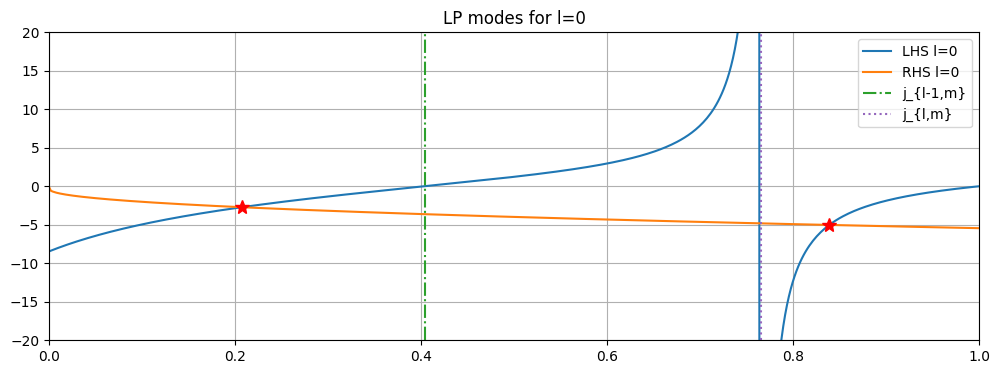

Nm(1) = 1


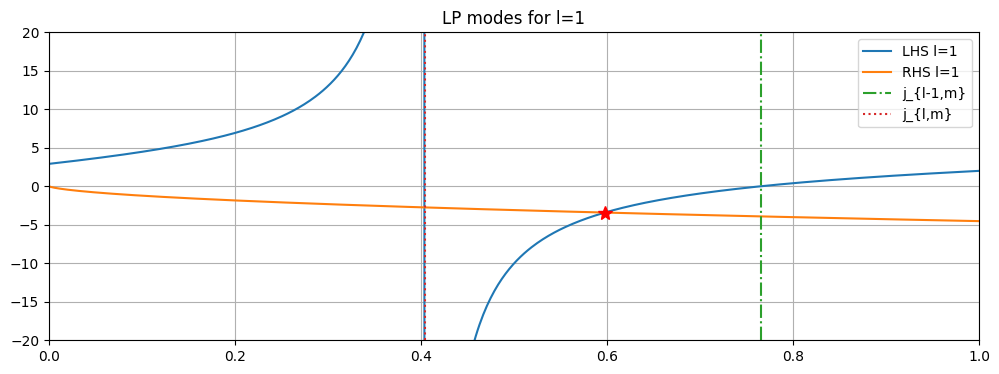

Nm(2) = 1


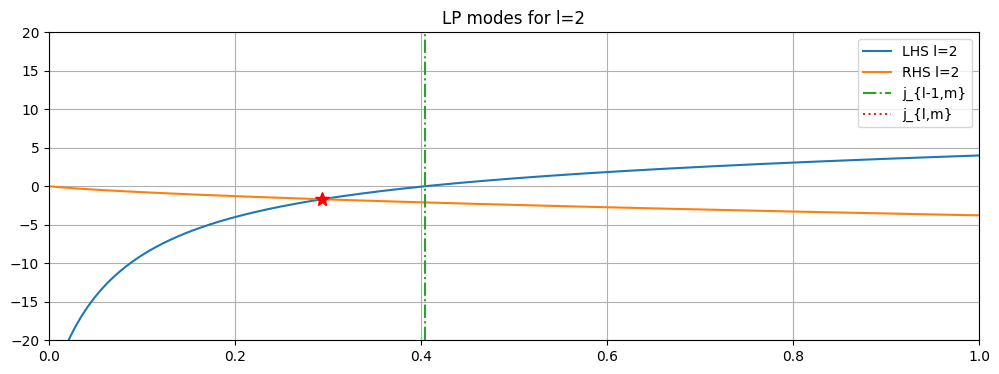

In [90]:
b = np.linspace(eps, 1 - eps, 500)
for l, Nm in enumerate(N_lm):
    print(f"Nm({l}) = {Nm}")
    fig, ax = plt.subplots(figsize=(12, 4))
    h = [
        ax.plot(b, LHS(U(V, b), l), label=f"LHS {l=}"),
        ax.plot(b, RHS(W(V, b), l), label=f"RHS {l=}"),
        [
            ax.plot(
                [bu(V, j0)] * 2,
                [-20, 20],
                "-.",
                label="j_{l-1,m}",
            )
            for j0 in special.jn_zeros(l - 1, Nm)
        ][0],
        [
            ax.plot(
                [bu(V, j0)] * 2,
                [-20, 20],
                ":",
                label="j_{l,m}",
            )
            for j0 in special.jn_zeros(l, Nm)
        ][0],
    ]
    ax.plot(b_sol[l], LHS(U(V, np.array(b_sol[l])), l), "r*", markersize=10)
    ax.grid()
    ax.set_ylim([-20, 20])
    ax.set_xlim([0, 1])
    ax.legend(handles=[hi[0] for hi in h], loc="upper right")
    ax.set_title(f"LP modes for l={l}")
    plt.show()

In [91]:
# Refractive indices
print(n_clad, n_core)

# beta should be bounded by the cladding/core refractive indices as follows:
print(round(n_clad*k0, 6), round(n_core*k0, 6))

1.4570121246412515 1.4604397732709191
14.462365 14.496388


In [92]:
# Display values
print(json.dumps(modes, indent=2))

[
  {
    "l": 0,
    "m": 1,
    "beta": 14.490916
  },
  {
    "l": 0,
    "m": 2,
    "beta": 14.469425
  },
  {
    "l": 1,
    "m": 1,
    "beta": 14.48271
  },
  {
    "l": 2,
    "m": 1,
    "beta": 14.472363
  }
]


In [93]:
(beta, beta[0], u, w)

([[14.49091593240132, 14.469425035850566],
  [14.482709714518295],
  [14.472362565987776]],
 [14.49091593240132, 14.469425035850566],
 array([0.39827886, 0.88374755]),
 array([0.90919595, 0.45194423]))

In [133]:
kr_max = np.sqrt(k0**2 - (n_core**2 - n_clad**2))
r_max = 10*a

j0 = special.jn_zeros(0, 10)
while j0[-1]<kr_max*r_max:
    j0 = special.jn_zeros(0, 2*len(j0))
    
h = HT(r_max, sum(j0<=1.5*kr_max*r_max), 0)
hf = col(h.JV) * h.T / row(h.JR)
hb = col(h.JR) * h.T / row(h.JV)

# rho = np.linspace(0, 1, 1<<8)*r_max/a
# ind_core = (rho<=1)
# ind_clad = ~ind_core

ind_core = (h.r<=a)
ind_clad = ~ind_core

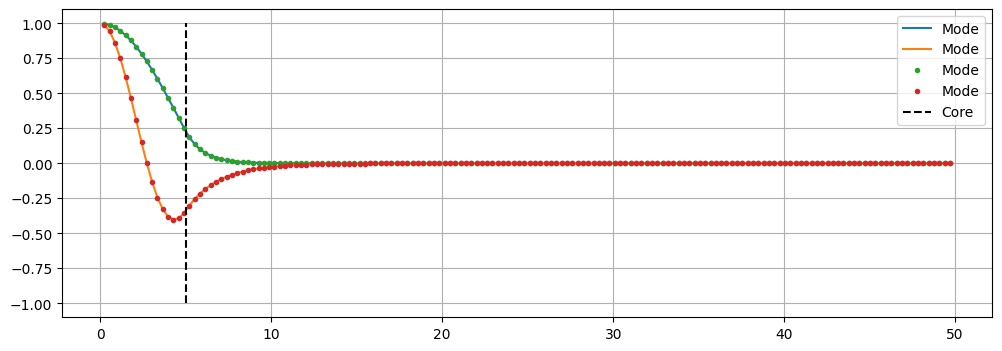

In [134]:

u = np.sqrt((n_core*k0)**2 - np.array(beta[0])**2)
w = np.sqrt(np.array(beta[0])**2 - (n_clad*k0)**2)

psi = np.vstack((special.j0(u*col(h.r[ind_core])), special.j0(u*a)/special.k0(w*a) * special.k0(w*col(h.r[ind_clad]))))

fig, ax = plt.subplots(figsize=(12, 4))
# ax.semilogy(rho, abs(psi), label="Mode")
ax.plot(h.r, psi, label="Mode")
ax.plot(h.r, hb @ (hf@psi), ".", label="Mode")
ax.plot([a]*2, [-1, 1], "k--", label="Core")
ax.grid()
ax.legend()
plt.show()



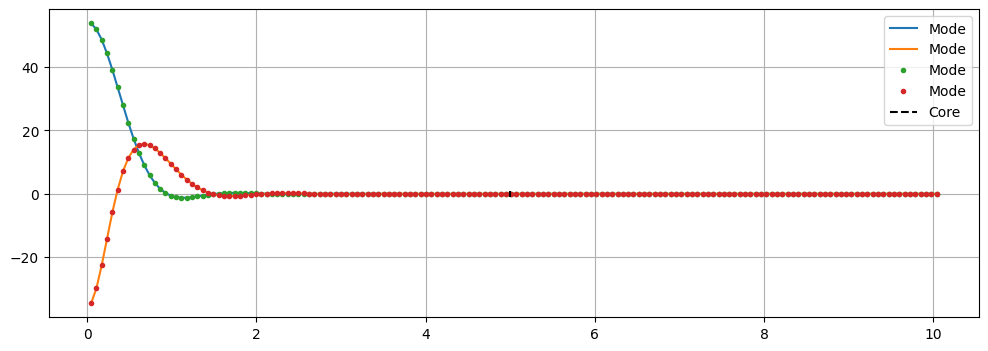

In [135]:
# (JV * np.matmul(self.T, (fr / JR))).reshape(N)



fig, ax = plt.subplots(figsize=(12, 4))
# ax.semilogy(rho, abs(psi), label="Mode")
ax.plot(h.kr, h.tofreq(psi), label="Mode")
ax.plot(h.kr, hf@psi, ".", label="Mode")
ax.plot([a]*2, [-1, 1], "k--", label="Core")
ax.grid()
ax.legend()
plt.show()


In [136]:
D = hb @ (-col(h.kr**2) * hf) + np.diag(k0**2*(ind_core*n_core**2 + ind_clad*n_clad**2))
# D = -col(h.kr**2) * hb  + np.diag(k0**2*(ind_core*n_core**2 + ind_clad*n_clad**2))
W = np.real(linalg.eigvals(D))
# print(np.real(W))
# print(np.sqrt(W))
print(sum(W<(k0*n_clad)**2), sum(W>(k0*n_core)**2))
W = np.sqrt(W[W>=(k0*n_clad)**2])
print(W, beta[0], W-beta[0])

158 0
[14.49102505 14.46985532] [14.49091593240132, 14.469425035850566] [0.00010912 0.00043029]
